# Downloading data from ECCO site

In [1]:
import warnings
warnings.filterwarnings('ignore')

from importlib import reload
from os import listdir,mkdir
import requests
from fsspec.implementations.http import HTTPFileSystem as HTTPFS
import ipywidgets as widgets
from IPython.display import display

In [2]:
from spectral_analysis.preprocess.common_vars import data_folder
prnt = '{}/LLC2160'.format(data_folder)

In [3]:
# Create output folder
def mkdir_ (folder,logError=True):
	#print(folder)
	try:
		mkdir(folder)
		print('Created folder: {}'.format(folder))
	except (FileExistsError):
		if logError:
			print('Folder already exists -- Creation skipped')
		pass

In [4]:
mkdir_(prnt)

Created folder: /home/antonio/GoogleDrive/Tesis/spectral_analysis_data/LLC2160


In [0]:
def isFolder(url,url_folder):
	forbidden_ch = ['.','?','#',':']
	fname = url.rsplit('/',1)[1]
	if fname=='':
		#print('empty',fname)
		return False
	elif any(c in forbidden_ch for c in fname):
		#print('Forbidden: '+fname)
		return False
	elif len(url.rsplit('?dir=',1))>1:
		#url_parts = url.rsplit('?dir=',1)
		folder = url.rsplit('?dir=',1)[1]
		#print(folder)
		return (url_folder+'/'+fname)==folder
	else:
		return False

In [0]:
# Reading folders from https://data.nas.nasa.gov/ecco/data.php?dir=/eccodata/llc_4320/regions
http_folder = '/eccodata/llc_2160/grid'
prnt_url = 'https://data.nas.nasa.gov/ecco/data.php?dir='+http_folder
download_cmd = 'https://data.nas.nasa.gov/ecco/download_data.php?file='
http_fs = HTTPFS(prnt_url)
#http_fs.ls(prnt_url,detail=False)
regions = [url.rsplit('/',1)[1] for url in http_fs.ls(prnt_url,detail=False) if isFolder(url,http_folder)]
#regions

In [0]:
region = None
region_folder = None
region_url = None

#https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/
select_region = widgets.Dropdown(
    options=regions,
    #value='2',
    description='Pick a region',
    disabled=False,
)
output_region = widgets.Output()

def on_regionpick(reg):
	if reg.type=='change':
		global region # Allows us to set outer variable
		global region_folder 
		global region_url
		#with output_region:
		region = reg.new
		region_folder = http_folder+"/"+region
		region_url = prnt_url+'/'+region
		print("Selected region: {} ({})".format(region,region_url))

select_region.observe(on_regionpick,names='value')
display(select_region)

Dropdown(description='Pick a region', options=(), value=None)

In [0]:
def isVar(url,region_folder):
	fname = url.rsplit('/',1)[1]
	#return fname in ["Eta", "Salt", "Theta", "U", "V", "W","grid"]  
	return fname in ["Eta", "U", "V","grid"]

In [0]:
def is_downloadable(url,var_folder):
	parts = url.rsplit('?file=',1)
	#print(parts)
	if len(parts)<2:
		return False,None,None
	else:
		fname = url.rsplit("/",1)[1]
		#print(fname)
		#print("Comparing {}/{} AND {}".format(var_folder,fname,parts[1]))
		return (var_folder+'/'+fname)==parts[1],parts[1],fname
		#"""
		#Does the url contain a downloadable resource
		#"""
		#h = requests.head(url, allow_redirects=True)
		#header = h.headers
		#content_type = header.get('content-type')
		#if 'text' in content_type.lower():
		#    return False
		#if 'html' in content_type.lower():
	  #    return False

In [0]:
import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')

def download_file(varname,url,fname):
    folder = "{}/{}".format(prnt,varname)
    mkdir_(folder,False)
    if fname.endswith(".data") or fname.endswith(".meta"):
        full_fname="{}/{}".format(folder,fname)
    else:
        full_fname="{}/{}.data".format(folder,fname)
    logging.info("Downloading {}".format(url))
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(full_fname, "wb") as handle:
            #for data in tqdm(response.iter_content()):
            handle.write(response.content)
        logging.info("File downloaded into {}".format(full_fname))
    else:
        logging.warning("Response status code: {}".format(response.status_code))

## Descargando malla

In [0]:
# Esto solo funciona para descargar la malla por separado
var_url = prnt_url
var = "grid"
print(var_url)
var_folder = http_folder
idw = 0
for url_f in http_fs.ls(var_url,detail=False):
    canDownload,fname_path,fname = is_downloadable(url_f,var_folder)
    if canDownload:
        idw = idw+1
        if idw>32:
            download_url = "{}{}".format(download_cmd,fname_path)
            download_file(var,download_url,fname)

In [0]:
from xmitgcm import open_mdsdataset
import numpy as np

In [0]:
ds_grid = open_mdsdataset(prnt+'/grid/', read_grid=True, iters=None, default_dtype=np.float32, geometry='llc')

/usr/local/lib/python3.6/dist-packages/xmitgcm/mds_store.py:846: UserWarning: Couldn't find available_diagnostics.log in /gdrive/My Drive/LLC2160/grid/ or /gdrive/My Drive/LLC2160/grid/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [0]:
ds_grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 2160, i_g: 2160, j: 2160, j_g: 2160, k: 90, k_l: 90, k_p1: 91, k_u: 90)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 2160, 2160), chunksize=(1, 2160, 2160)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 2160, 2160), chunksize=(1, 2160, 2160)

In [0]:
ds_grid.Zl.values ## z=-500 m está en el índice 40

array([ 0.00000e+00, -1.00000e+00, -2.14000e+00, -3.44000e+00,
       -4.93000e+00, -6.63000e+00, -8.56000e+00, -1.07600e+01,
       -1.32600e+01, -1.61000e+01, -1.93100e+01, -2.29400e+01,
       -2.70400e+01, -3.16500e+01, -3.68300e+01, -4.26200e+01,
       -4.90900e+01, -5.62900e+01, -6.42700e+01, -7.31000e+01,
       -8.28300e+01, -9.35200e+01, -1.05220e+02, -1.17980e+02,
       -1.31850e+02, -1.46880e+02, -1.63100e+02, -1.80550e+02,
       -1.99250e+02, -2.19220e+02, -2.40490e+02, -2.63050e+02,
       -2.86920e+02, -3.12090e+02, -3.38550e+02, -3.66290e+02,
       -3.95290e+02, -4.25530e+02, -4.56980e+02, -4.89630e+02,
       -5.23450e+02, -5.58420e+02, -5.94510e+02, -6.31710e+02,
       -6.70000e+02, -7.09370e+02, -7.49820e+02, -7.91350e+02,
       -8.33970e+02, -8.77700e+02, -9.22570e+02, -9.68620e+02,
       -1.01590e+03, -1.06446e+03, -1.11439e+03, -1.16577e+03,
       -1.21870e+03, -1.27331e+03, -1.32973e+03, -1.38811e+03,
       -1.44864e+03, -1.51151e+03, -1.57694e+03, -1.645

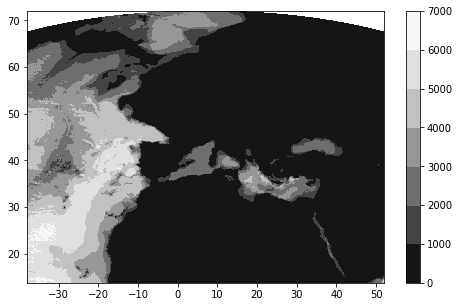

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
LAT = ds_grid.YC.isel(face=2).values
LON = ds_grid.XC.isel(face=2).values
DEPTH = ds_grid.Depth.isel(face=2).values
_c = plt.contourf(LON,LAT,DEPTH,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

97.96856
2249.761


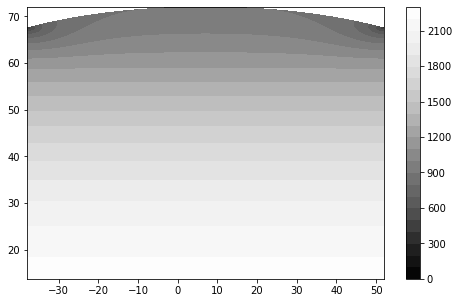

In [0]:
plt.figure(figsize=(8,5))
DX = ds_grid.dxC.isel(face=2).values/2
print(np.min(DX))
print(np.max(DX))
_c = plt.contourf(LON,LAT,DX,25,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

106.98673
2072.4924


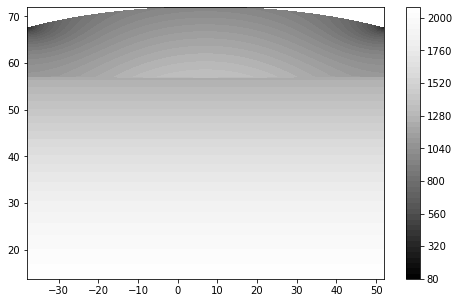

In [0]:
plt.figure(figsize=(8,5))
DY = ds_grid.dyC.isel(face=2).values/2
print(np.min(DY))
print(np.max(DY))
_c = plt.contourf(LON,LAT,DY,50,cmap=plt.cm.Greys_r)
plt.colorbar(_c)
plt.show()

In [0]:
# Downloading variables from https://data.nas.nasa.gov/ecco/data.php?dir=/eccodata/llc_4320/regions/<region>
# Consider timestamp format: https://github.com/dcherian/tools/blob/master/mitgcm/matlab/cs_grid/read_cs/dte2ts.m
for var in [url.rsplit('/',1)[1] for url in http_fs.ls(region_url,detail=False) if isVar(url,region_folder)]:
	var_url = region_url+"/"+var
	var_folder = region_folder+"/"+var
	print("Reading variable {} ({})".format(var,var_url))
	for url_f in http_fs.ls(var_url,detail=False):
		canDownload,fname_path,fname = is_downloadable(url_f,var_folder)
		if canDownload:
			download_url = "{}{}".format(download_cmd,fname_path)
			download_file(var,download_url,fname)

#print(vars) 

## Leyendo archivos descargados

In [0]:
#!pip install --upgrade fsspec zarr git+https://github.com/xgcm/xmitgcm.git

In [0]:
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image, HTML


In [0]:
data_shape = (240,577)

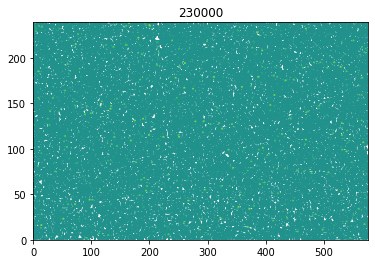

In [0]:
#ds_V = np.memmap("{}/{}".format(prnt,"V_tmp"),mode='w+',dtype="float32",shape=(240,577,20))

plt.ion(); plt.figure(1);
#def animate(t_):
for t_ in range(24):
    plt.clf()
    #ax.clear()
    t = t_*10000
    fname_U = "U_240x577x85.20110913T{:06d}.data".format(t)
    fname_V = "V_240x577x85.20110913T{:06d}.data".format(t)
    #print(fname_V)
    U = np.memmap("{}/{}".format(prnt,fname_U),mode='r',dtype='float32',shape=data_shape)
    #V = np.memmap("{}/{}".format(prnt,fname_V),mode='r',dtype='float32',shape=data_shape)
    #UV = np.sqrt(np.square(U) + np.square(V))
    #ax.contour(U)
    #ax.set_title('%06d'%(t))
    #plt.clf()
    plt.contour(U)
    plt.title('%06d'%(t))
    plt.draw()
    del U
    #del V

#fig,ax = plt.subplots()
#ani = animation.FuncAnimation(fig,animate,20,interval=100,blit=False)
#plt.close(ani._fig)
#HTML(ani.to_html5_video())

In [0]:
np.fla

# Fetching data directly with LLC tool (xmitgcm.llcreader)

In [0]:
#Dependencies
!pip install --upgrade geopandas dask zarr datashader intake fsspec git+https://github.com/xgcm/xmitgcm.git

In [0]:
%%script false
import dask,xmitgcm,numpy
print(dask.__version__)
print(xmitgcm.__version__)
print(numpy.__version__)

In [0]:
map_res = 48

In [0]:
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from xmitgcm import llcreader
if map_res==24:
    model = llcreader.ECCOPortalLLC2160Model()
elif map_res==48:
    model = llcreader.ECCOPortalLLC4320Model()
else:
    raise Exception("Invalid resolution")
model.varnames

['Eta',
 'KPPhbl',
 'oceFWflx',
 'oceQnet',
 'oceQsw',
 'oceSflux',
 'oceTAUX',
 'oceTAUY',
 'PhiBot',
 'Salt',
 'SIarea',
 'SIheff',
 'SIhsalt',
 'SIhsnow',
 'SIuice',
 'SIvice',
 'Theta',
 'U',
 'V',
 'W']

In [0]:
cols2drop = ['time']
map_mode = 'faces' # 'faces' or 'latlon'

if map_mode=='faces':
    cols2drop=['time','niter','face']
    cols2drop_uv=['time','niter','face','k']
    cols2drop_w=['time','niter','face','k_l']

In [0]:
model_vars = ["Eta","U","V","W"]
#ds = model.get_dataset(varnames=model_vars,type='latlon',k_levels=[0,29,59,89],iter_start=10368,iter_stop=11368,iter_step=80,k_chunksize=1) # delta_t = 45 s, 80*45=3600 s = 1h
ds = model.get_dataset(varnames=model_vars,k_levels=[0,29,59,89],k_chunksize=1,type=map_mode)
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 4, k_l: 4, k_p1: 4, k_u: 4, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 0 29 59 89
  * k_u      (k_u) int64 0 29 59 89
  * k_l      (k_l) int64 0 29 59 89
  * k_p1     (k_p1) int64 0 29 59 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<shape=(9030, 13, 4320, 4320), chunksize=(1, 3, 4320, 4320)>
    U        (time, k, face, j, i_g) float32 dask.array<shape=(9030, 4, 13, 4320, 4320), chunksize=(1, 1, 3, 4320, 4320)>


In [0]:
ds.time.values

array(['2011-03-06T00:00:00.000000000', '2011-03-06T01:00:00.000000000',
       '2011-03-06T02:00:00.000000000', ...,
       '2013-04-22T04:00:00.000000000', '2013-04-22T05:00:00.000000000',
       '2013-04-22T06:00:00.000000000'], dtype='datetime64[ns]')

In [0]:
ds.nbytes / (1024*1024*1024) # En GB

54866.587957940996

## Tomando la parte de Canarias

Al tomar los datos al estilo _faces_, podemos elegir [una de las 13 caras](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html) (_faces_ o _tiles_), para ahorrar memoria al momento de cargarla.

**La corriente de Benguela está en la cara 2**.



In [0]:
area_face=2

In [0]:
ds_eta = ds.Eta.isel(time=0,face=area_face)
ds_eta

<xarray.DataArray 'Eta' (j: 2160, i: 2160)>
dask.array<shape=(2160, 2160), dtype=float32, chunksize=(2160, 2160)>
Coordinates:
    face     int64 2
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 2153 2154 2155 2156 2157 2158 2159
    niter    int64 ...
    time     datetime64[ns] 2011-03-06
Attributes:
    standard_name:  ETAN
    long_name:      Surface Height Anomaly
    units:          m

In [0]:
# Índices para longitud (i) y latitud (j) -- necesitamos convertirlos a grados (lat-lon)
i = ds_eta.i.values
j = ds_eta.j.values


In [0]:
ds_eta.nbytes / (1024*1024*1024) # Tamaño en GB

0.017380714416503906

In [0]:
df_pd = ds_eta.to_dataframe()
df_pd.reset_index(inplace=True)
df_pd.head()

,j,i,face,niter,time,Eta
0,0,0,2,92160,2011-03-06,-0.329067
1,0,1,2,92160,2011-03-06,-0.331295
2,0,2,2,92160,2011-03-06,-0.333070
3,0,3,2,92160,2011-03-06,-0.330459
4,0,4,2,92160,2011-03-06,-0.326806


In [0]:
# Eliminamos el tiempo por ahora, ya que es igual
# Al hacer pivot_table, le damos la forma de matriz
#df = dd.from_pandas(df_pd,npartitions=4*multiprocessing.cpu_count()).drop('time',axis=1)
#df = df.categorize(columns=['i']).pivot_table(index='j',columns='i',values='Eta')
#df.head()

In [0]:
## Version sin Dask de lo mismo
df = df_pd.drop(cols2drop,axis=1).pivot_table(index='j',columns='i',dropna=False)
print(df.shape)
df.head()

(4320, 4320)


Eta                      ...                              
i      0         1         2     ...      4317      4318      4319
j                                ...                              
0 -0.448366 -0.440952 -0.436159  ... -0.033656 -0.030120 -0.020208
1 -0.438551 -0.434066 -0.433424  ... -0.027057 -0.022929 -0.011920
2 -0.434806 -0.432563 -0.433054  ... -0.024203 -0.018085 -0.004005
3 -0.439119 -0.435423 -0.433725  ... -0.023352 -0.014397  0.002233
4 -0.446596 -0.440570 -0.436257  ... -0.011897  0.000229  0.018112

[5 rows x 4320 columns]

In [0]:
vals_np = df.values
vals_np.shape

(4320, 4320)

In [0]:
print(len(i))
print(len(j))

4320
4320


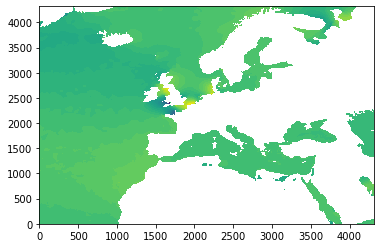

In [0]:
plt.contourf(i,j,vals_np,50)
plt.show()

### Conversión de índices a latitud-longitud

Necesitamos "convertir" los índices (i,j) a (lon,lat)

La caja 2 tiene los siguientes rangos (aproximados):
 - Longitud: -35 a 55 (90 grados)
 - Latitud: 13.5 a 71 (57.5 grados)

In [0]:
# La longitud es sencilla de convertir
min_lon = -35
lon = min_lon+i/map_res

lon_i = ((lon_,i_,1/map_res) for lon_,i_ in zip(lon,i))
lon_i_df = pd.DataFrame(lon_i,columns=["lon","i","d_lon"])
lon_i_df.set_index("lon",inplace=True)
lon_i_df.head()

,i,d_lon
lon,,
-35.000000,0,0.020833
-34.979167,1,0.020833
-34.958333,2,0.020833
-34.937500,3,0.020833
-34.916667,4,0.020833


In [0]:
j.shape

(4320,)

In [0]:
min_lat = 13.5
#max_lat = 71 # Algo así deberíamos de obtener en max(lat)
lat = np.zeros((len(j),))
lat[0] = min_lat
del_lat = np.zeros((len(j),))
del_lat[0] = np.cos(min_lat*np.pi/180)/map_res
for jj in range(1,len(j)):
    del_lat[jj] = np.cos(lat[jj-1]*np.pi/180)/map_res
    lat[jj] = lat[jj-1] + del_lat[jj]
print(min(lat))
print(max(lat))

lat_j = ((lat_,j_,dlat) for lat_,j_,dlat in zip(lat,j,del_lat))
lat_j_df = pd.DataFrame(lat_j,columns=["lat","j","d_lat"])
lat_j_df.set_index("lat",inplace=True)
lat_j_df.head()

13.5
71.38335329631715


,j,d_lat
lat,,
13.500000,0,0.020258
13.520258,1,0.020258
13.540514,2,0.020256
13.560768,3,0.020254
13.581020,4,0.020253


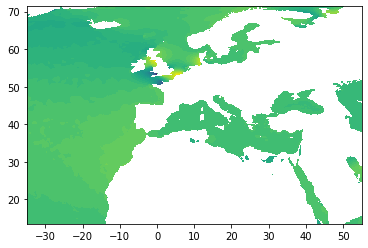

In [0]:
plt.contourf(lon,lat,vals_np,50)
plt.show()

### Usamos la conversión para seleccionar la región que nos interesa

Tomaremos, por ejemplo, la caja 771, ya que vemos una clara partición BM/IGW cerca a los 60 km.

La caja está centrada en lon=-23, y lat=31.462

Para ser más exactos, usaremos los límites calculados previamente

In [0]:
area_id = 771

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Directorio de los datos geográficos
prnt_map = '/gdrive/My Drive/Tesis/spectral_analysis/map_data'
geodata = gpd.read_file('{}/{}_{}_geo.json'.format(prnt_map,'RV',"ASO"),driver='GeoJSON')
data_area = geodata[geodata["s_id"]==area_id].drop(columns=["season","var"])
data_area

,height_km,lon,lat,s_id,width_km,geometry
711,525.611111,-23.0,31.462,771,568.657674,"POLYGON ((-26.00000 29.09675, -26.00000 33.827..."


In [0]:
area_box = data_area['geometry'].values[0]
lon_min,lat_min,lon_max,lat_max = area_box.bounds
print(area_box.bounds)
#lon_min=-26
#lon_max = -24
#lat_min = 32.8
#lat_max = 33.8

(-26.0, 29.096750000000014, -20.0, 33.827249999999985)


In [0]:
i_area = lon_i_df[lon_min:lon_max]["i"].values
j_area = lat_j_df[lat_min:lat_max]["j"].values

In [0]:
print(len(i_area))
print(len(j_area))

289
267


In [0]:
lon_area = lon_i_df[lon_min:lon_max].index.values
lat_area = lat_j_df[lat_min:lat_max].index.values

In [0]:
#
min_i = i_area[0]
max_i = i_area[-1]
min_j = j_area[0]
max_j = j_area[-1]
#

In [0]:
ds_area = ds.isel(face=area_face,
                  i=slice(min_i,max_i+1),j=slice(min_j,max_j+1),
                  i_g=slice(min_i,max_i+1),j_g=slice(min_j,max_j+1)
                  )
ds_area

<xarray.Dataset>
Dimensions:  (i: 289, i_g: 289, j: 267, j_g: 267, k: 4, k_l: 4, k_p1: 4, k_u: 4, time: 9030)
Coordinates:
    face     int64 2
  * i        (i) int64 432 433 434 435 436 437 438 ... 715 716 717 718 719 720
  * i_g      (i_g) int64 432 433 434 435 436 437 438 ... 715 716 717 718 719 720
  * j        (j) int64 807 808 809 810 811 812 ... 1068 1069 1070 1071 1072 1073
  * j_g      (j_g) int64 807 808 809 810 811 812 ... 1069 1070 1071 1072 1073
  * k        (k) int64 0 29 59 89
  * k_u      (k_u) int64 0 29 59 89
  * k_l      (k_l) int64 0 29 59 89
  * k_p1     (k_p1) int64 0 29 59 89
    niter    (time) int64 ...
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    Eta      (time, j, i) float32 dask.array<shape=(9030, 267, 289), chunksize=(1, 267, 289)>
    U        (time, k, j, i_g) float32 dask.array<shape=(9030, 4, 267, 289), chunksize=(1, 1, 267, 289)>
    V        (time, k, j_g, i) float32 dask.array<shape=(9030, 4, 267, 289), ch

In [0]:
ds_area.nbytes / (1024*1024*1024) # En GB

33.74443556368351

#### Tomamos variable por variable, en t=0

##### U, z=0

In [0]:
ds_u = ds_area.U.isel(time=0,k=0)
ds_u

<xarray.DataArray 'U' (j: 267, i_g: 289)>
dask.array<shape=(267, 289), dtype=float32, chunksize=(267, 289)>
Coordinates:
    face     int64 2
  * i_g      (i_g) int64 432 433 434 435 436 437 438 ... 715 716 717 718 719 720
  * j        (j) int64 807 808 809 810 811 812 ... 1068 1069 1070 1071 1072 1073
    k        int64 0
    niter    int64 ...
    time     datetime64[ns] 2011-09-13
Attributes:
    standard_name:  sea_water_x_velocity
    mate:           V
    long_name:      Zonal Component of Velocity
    units:          m s-1

In [0]:
df_u_pd = ds_u.to_dataframe()
df_u_pd.reset_index(inplace=True)
df_u_pd.head()

,j,i_g,face,k,niter,time,U
0,807,432,2,0,10368,2011-09-13,0.101264
1,807,433,2,0,10368,2011-09-13,0.097676
2,807,434,2,0,10368,2011-09-13,0.105019
3,807,435,2,0,10368,2011-09-13,0.129251
4,807,436,2,0,10368,2011-09-13,0.170941


In [0]:
set(df_u_pd["k"].values)

{0}

In [0]:
df_u = df_u_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j',columns='i_g',dropna=False)
print(df_u.shape)
df_u.head()

(267, 289)


U                      ...                              
i_g       432       433       434  ...       718       719       720
j                                  ...                              
807  0.101264  0.097676  0.105019  ... -0.092066 -0.100751 -0.100697
808  0.131291  0.132437  0.133723  ... -0.073228 -0.072763 -0.070793
809  0.159845  0.159326  0.151846  ... -0.056040 -0.049163 -0.047758
810  0.185422  0.176312  0.158454  ... -0.039102 -0.030312 -0.032224
811  0.202498  0.184194  0.161070  ... -0.023737 -0.015882 -0.021544

[5 rows x 289 columns]

(267, 289)


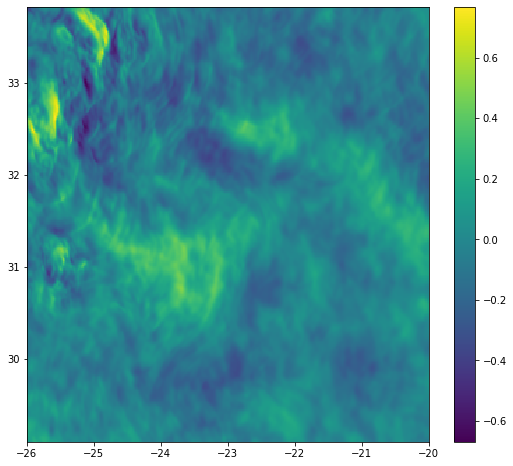

In [0]:
vals_u = df_u.values
print(vals_u.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_u)
plt.colorbar(_cs)
plt.show()

##### V, z=0

(267, 289)


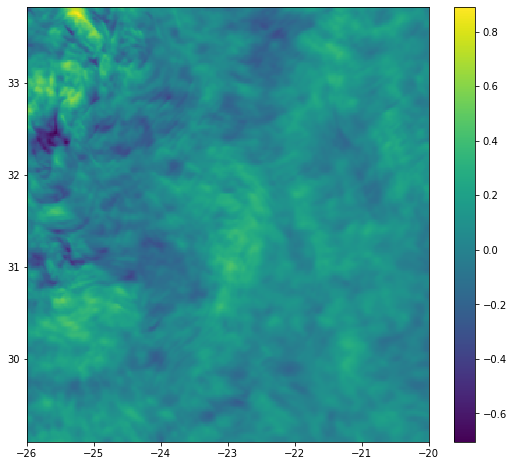

In [0]:
df_v_pd = ds_area.V.isel(time=0,k=0).to_dataframe()
df_v_pd.reset_index(inplace=True)
df_v = df_v_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_v = df_v.values
print(vals_v.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_v)
plt.colorbar(_cs)
plt.show()

##### Velocidad en z=0

In [0]:
U = np.sqrt(np.square(vals_u) + np.square(vals_v))

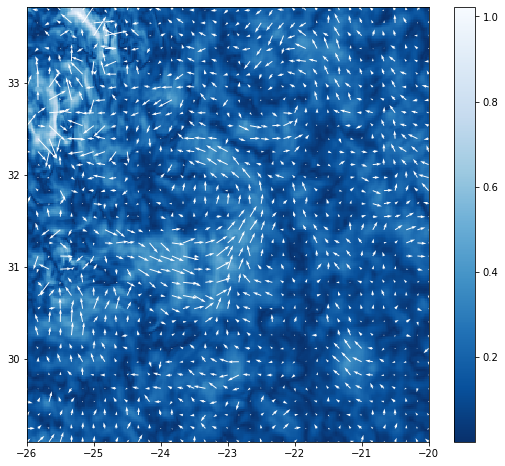

In [0]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,U,cmap=plt.cm.Blues_r)
plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.colorbar(_cs)
plt.show()

##### Energía cinética (KE) en z=0

In [0]:
KE = np.square(U)/2

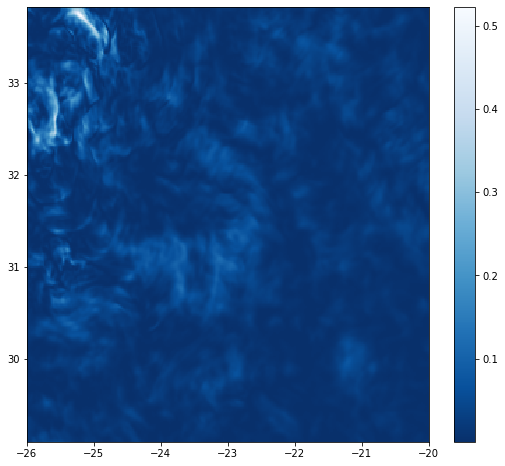

In [0]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,KE,cmap=plt.cm.Blues_r)
#plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.colorbar(_cs)
plt.show()

###### Transformada de Fourier de KE

Ver [pregunta en SO](https://dsp.stackexchange.com/questions/724/low-pass-filter-and-fft-for-beginners-with-python/725#725) para información sobre consideraciones en el uso de un filtro "ideal"

In [0]:
max_dx = np.max(dxdy)
min_dx = np.min(dxdy)
print(max_dx)
print(min_dx)
print("Diferencia entre intervalos de muestreo: {0:.2f}%".format(100*(max_dx-min_dx)/max_dx))
# Esta diferencia porcentual nos permite hacer la FFT como si los puntos estuvieran en una malla cuadriculada
dxdy_avg = (max_dx + min_dx)/2
print("Usaremos un delta_xy promedio de {0:.3f} km".format(dxdy_avg/1000))

2024.1130747087277
1924.4261686199561
Diferencia entre intervalos de muestreo: 4.92%
Usaremos un delta_xy promedio de 1.974 km


In [0]:
Nx = len(lon_area)
Lx = Nx*dxdy_avg
delta_kx = 1/Lx
Ny = len(lat_area)
Ly = Ny*dxdy_avg
delta_ky = 1/Ly

print("Se hace la FFT en una región cuadrangular de ~ {0:.2f} x {1:.2f} km, o {2}x{3} puntos".format(Lx/1000,Ly/1000,Nx,Ny))

Se hace la FFT en una región cuadrangular de ~ 570.56 x 527.13 km, o 289x267 puntos


In [0]:
KE_k = np.fft.fft2(KE)
KE_k_plt = np.fft.fftshift(KE_k)

In [0]:
N_kx = (Nx-1)/2
Kx = delta_kx*np.arange(-N_kx,N_kx+1)
N_ky = (Ny-1)/2
Ky = delta_ky*np.arange(-N_ky,N_ky+1)
print(len(Kx))
print(len(Ky))
print(1/(delta_kx*N_kx))

289
267
3962.249449034686


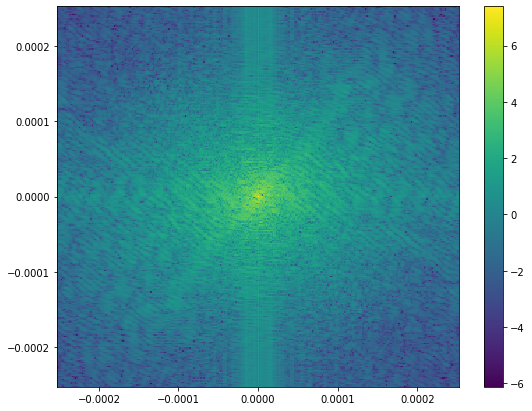

In [0]:
plt.figure(figsize=(9,7))
_c = plt.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_plt)))
plt.colorbar(_c)
plt.show()

###### Partimos los movimientos en largos y cortos

In [0]:
## Elegimos la longitud de onda a la que filtraremos
L_max = 50*1000 # 50 km, digamos
K_max = 1/L_max
kx_,ky_ = np.meshgrid(Kx,Ky)

# Las variables _plt solo se usan de forma auxiliar para las gráficas (plot)
filter_mask_plt = (np.square(kx_)+np.square(ky_) <= K_max**2).astype(np.float32)
filter_mask = np.fft.fftshift(filter_mask_plt)
filter_mask = filter_mask*np.fliplr(filter_mask) # Simetria en Kx
filter_mask = filter_mask*np.flipud(filter_mask) # Simetria en Ky

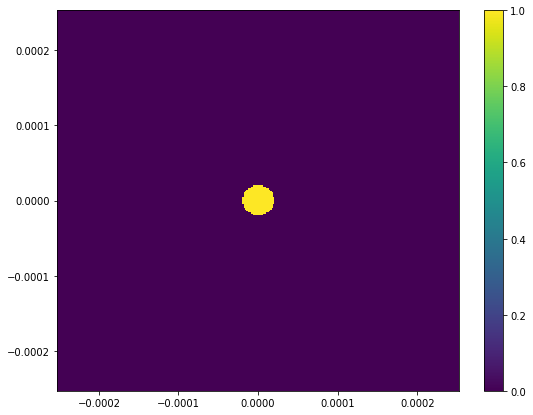

In [0]:
plt.figure(figsize=(9,7))
_c = plt.pcolormesh(Kx,Ky,filter_mask_plt)
plt.colorbar(_c)
plt.show()

In [0]:
# El cálculo de la inversa se hará sobre la variable a la que no se le aplica fftshift,
# ya que np.flipup y np.fliplr no conmutan con fftshift
KE_k_lo = KE_k*filter_mask
KE_k_hi = KE_k-KE_k_lo
#
KE_k_lo_plt = KE_k_plt*filter_mask_plt
KE_k_hi_plt = KE_k_plt-KE_k_lo_plt

In [0]:
# Forzamos que las matrices sean hermíticas
#idx_k = int((Nx-Ny)/2)
#KE_k_lo[:,idx_k:-idx_k] = (KE_k_lo[:,idx_k:-idx_k] + KE_k_lo[:,idx_k:-idx_k].T.conj())/2
#KE_k_hi[:,idx_k:-idx_k] = (KE_k_hi[:,idx_k:-idx_k] + KE_k_hi[:,idx_k:-idx_k].T.conj())/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


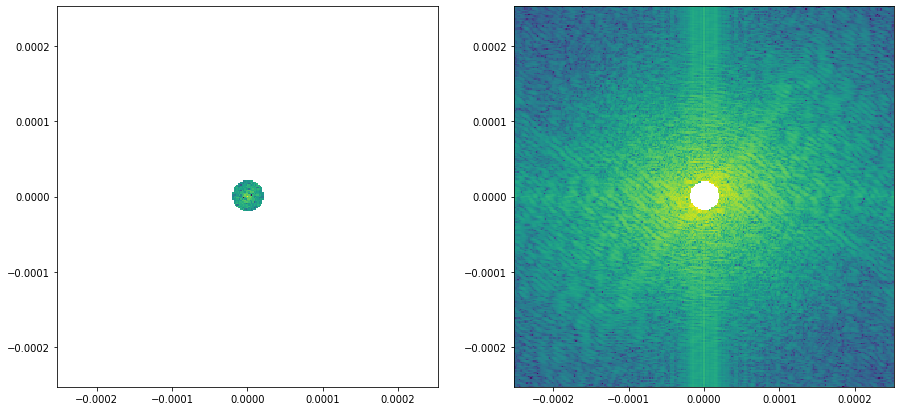

In [0]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c = ax1.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_lo_plt)))
_c = ax2.pcolormesh(Kx,Ky,np.log(np.abs(KE_k_hi_plt)))
#ax2.colorbar(_c)
fig.show()

###### Transformada inversa

In [0]:
_KE_lo = np.fft.ifft2(KE_k_lo)
_KE_hi = np.fft.ifft2(KE_k_hi)

print(np.max(np.abs(np.real(_KE_lo))))
print(np.max(np.abs(np.imag(_KE_lo))))
print(np.max(np.abs(np.real(_KE_hi))))
print(np.max(np.abs(np.imag(_KE_hi))))

0.19401652314130227
0.01442057828373373
0.3378210955577081
0.014420578283733715


In [0]:
KE_lo = np.real(_KE_lo)
KE_hi = np.real(_KE_hi)

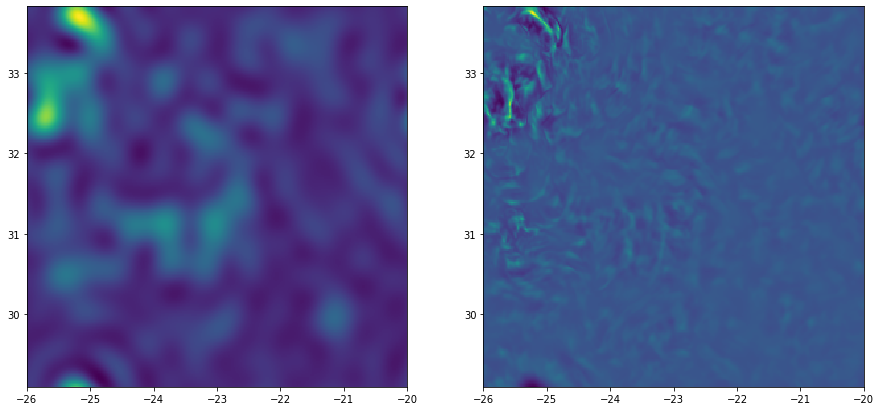

In [0]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
_c = ax1.pcolormesh(lon_area,lat_area,KE_lo)
_c = ax2.pcolormesh(lon_area,lat_area,KE_hi)
#ax2.colorbar(_c)
fig.show()

###### Verificamos el error inducido

In [0]:
KE_rec = KE_lo + KE_hi # KE "reconstruida"
KE_diff = np.abs(100*(KE-KE_rec)/KE) # Error relativo porcentual

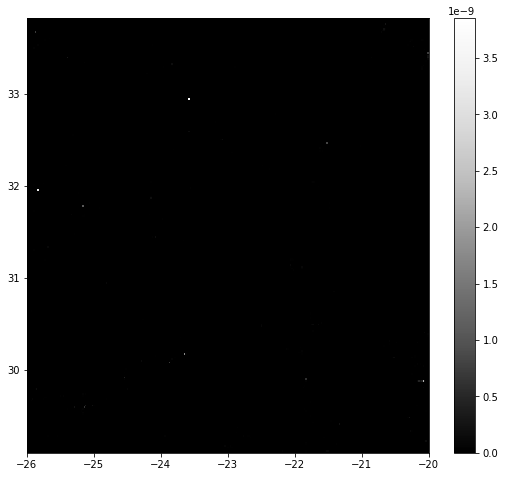

In [0]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,KE_diff,cmap=plt.cm.Greys_r)
plt.colorbar(_cs)
plt.show()

##### Prueba: cálculo de derivadas en ambas direcciones



In [0]:
tt = np.array([i for i in range(100)])
xy = np.cos(tt*2*np.pi/50)
zz = np.outer(xy,xy)

In [0]:
gradxy = np.gradient(zz)
gradx = gradxy[1] # gradient(zz,axis=0) hace la derivada sobre el eje 0 (las filas), es decir sobre X
grady = gradxy[0] # gradient(zz,axis=1) hace la derivada sobre el eje 1 (las columnas), es decir sobre Y
#gradx = np.gradient(zz,axis=1)
#grady = np.gradient(zz,axis=0)

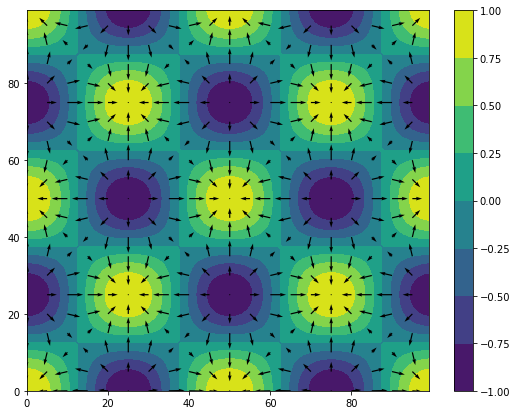

In [0]:
plt.figure(figsize=(9,7))
_c = plt.contourf(tt,tt,zz)
plt.quiver(tt[::5],tt[::5],gradx[::5,::5],grady[::5,::5])
plt.colorbar(_c)
plt.show()

##### Vorticidad planetaria

In [0]:
R = 6371*1000 # Radio de la Tierra, en metros
C = 2*np.pi*R # Circunferencia en el Ecuador
Omega = 2*np.pi/(24*3600) # Frecuencia de rotación terrestre
print(Omega)

7.27220521664304e-05


In [0]:
cos_lat = np.tile(np.cos(lat_area*np.pi/180).reshape((len(j_area),1)),(1,len(i_area)))

In [0]:
# Parámetro de coriolis: f = 2*Omega*cos(latitud)
f_cor = 2*Omega*cos_lat

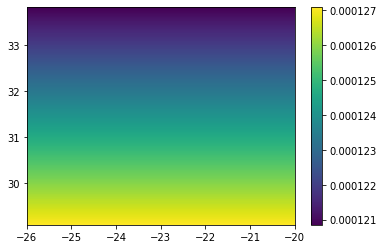

In [0]:
_c = plt.pcolormesh(lon_area,lat_area,f_cor)
plt.colorbar(_c)
plt.show()

##### Vorticidad relativa en z=0

In [0]:
dxdy = C*cos_lat/map_res/360

RV_0 = (np.gradient(vals_v,axis=1) - np.gradient(vals_u,axis=0))/dxdy

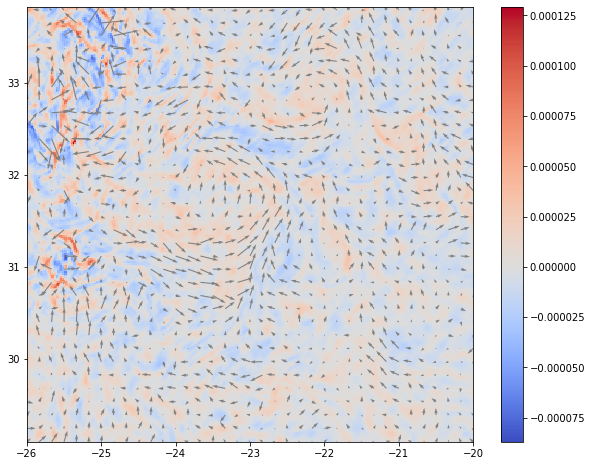

In [0]:
plt.figure(figsize=(10,8))
divnorm = colors.DivergingNorm(vmin=np.min(RV_0), vcenter=0, vmax=np.max(RV_0))

_cs = plt.pcolormesh(lon_area,lat_area,RV_0,norm=divnorm,cmap=plt.cm.coolwarm) # plt.cm.RdBu
plt.colorbar(_cs)
plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='gray')
plt.show()

##### Estiramiento en z=0

###### $\sigma_n$

In [0]:
sigma_n = (np.gradient(vals_u,axis=1) - np.gradient(vals_v,axis=0))/dxdy

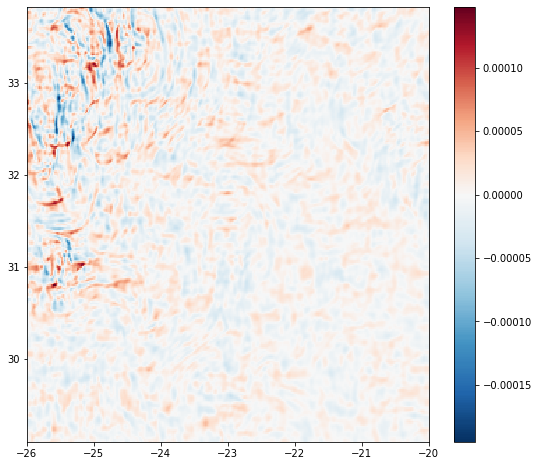

In [0]:
divnorm = colors.DivergingNorm(vmin=np.min(sigma_n), vcenter=0, vmax=np.max(sigma_n))

plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_n,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

###### $\sigma_s$

In [0]:
sigma_s = (np.gradient(vals_v,axis=1) + np.gradient(vals_u,axis=0))/dxdy

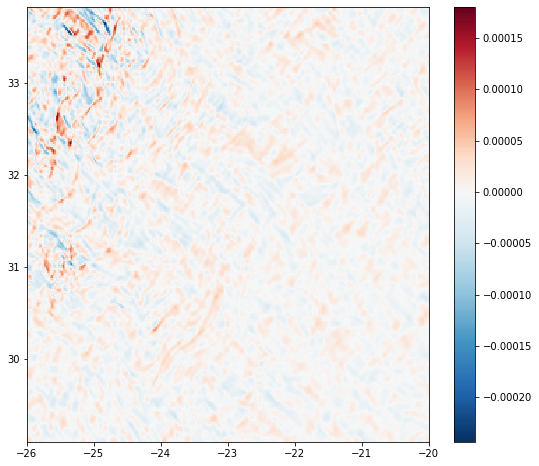

In [0]:
divnorm = colors.DivergingNorm(vmin=np.min(sigma_s), vcenter=0, vmax=np.max(sigma_s))
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_s,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

###### $\sigma_n^2 + \sigma_s^2$

In [0]:
sigma_sq = np.square(sigma_n) + np.square(sigma_s)

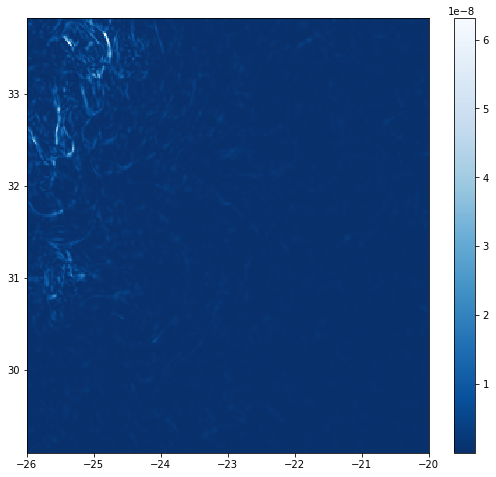

In [0]:
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,sigma_sq,cmap=plt.cm.Blues_r)
plt.colorbar(_cs)
plt.show()

##### Okubo-Weiss en z=0

In [0]:
RV_sq = np.square(RV_0)
OW = (sigma_sq - RV_sq)/4

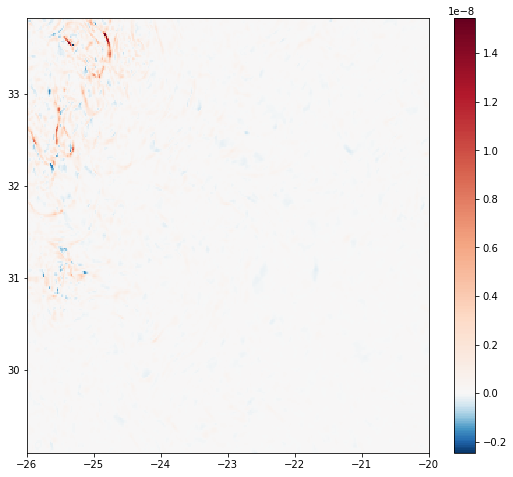

In [0]:
plt.figure(figsize=(9,8))
divnorm = colors.DivergingNorm(vmin=np.min(OW), vcenter=0, vmax=np.max(OW))

_cs = plt.pcolormesh(lon_area,lat_area,OW,norm=divnorm,cmap=plt.cm.RdBu_r)
plt.colorbar(_cs)
plt.show()

##### W en z=0

In [0]:
df_w_pd = ds_area.W.isel(time=0,k_l=0).to_dataframe()
df_w_pd.reset_index(inplace=True)
df_w = df_w_pd.drop(cols2drop_w,axis=1).pivot_table(index='j',columns='i',dropna=False)
vals_w = df_w.values

(267, 289)


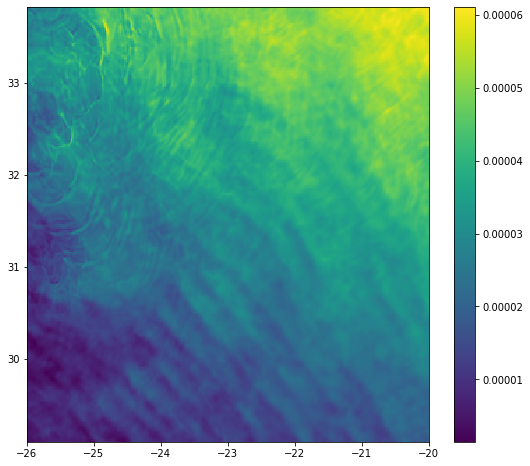

In [0]:
print(vals_w.shape)
plt.figure(figsize=(9,8))
_cs = plt.pcolormesh(lon_area,lat_area,vals_w)
plt.colorbar(_cs)
plt.show()

##### Número de Rossby baroclínico, con H=500 m

$Ro_b = \left|\frac{\zeta_b}{f}\right|$

con $\zeta_b = \zeta_{z=0 m} - \zeta_{z=-500 m}$

In [0]:
# U en z=-500 m
df_uH_pd = ds_area.U.isel(time=0,k=1).to_dataframe() ## Supondremos que 500m está en k=29
df_uH_pd.reset_index(inplace=True)
df_uH = df_vH_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_uH = df_uH.values

In [0]:
# V en z=-500 m
df_vH_pd = ds_area.V.isel(time=0,k=1).to_dataframe() ## Supondremos que 500m está en k=29
df_vH_pd.reset_index(inplace=True)
df_vH = df_vH_pd.drop(cols2drop_uv,axis=1).pivot_table(index='j_g',columns='i',dropna=False)
vals_vH = df_vH.values

In [0]:
RV_H = (np.gradient(vals_vH,axis=1) - np.gradient(vals_uH,axis=0))/dxdy

In [0]:
Ro_b = np.abs((RV_0-RV_H)/f_cor)

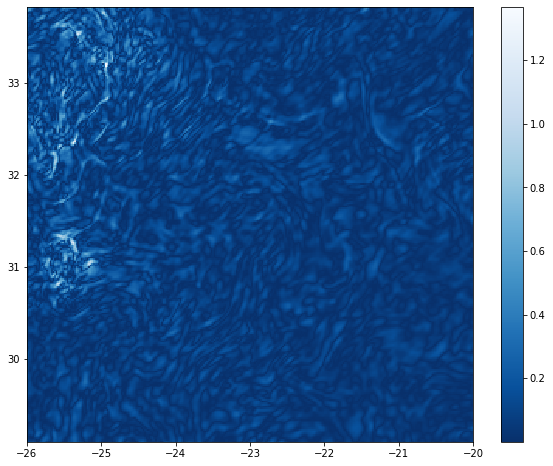

In [0]:
plt.figure(figsize=(10,8))

_cs = plt.pcolormesh(lon_area,lat_area,Ro_b,cmap=plt.cm.Blues_r)
plt.colorbar(_cs)
#plt.quiver(lon_area[::nn],lat_area[::nn],vals_u[::nn,::nn],vals_v[::nn,::nn],color='white')
plt.show()